In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import polyphase as phase
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True, "font.size":15}
)

plt.style.use('science')

In [12]:
SAVE_FIGS = False
MPL_INTERACTIVE = False
if MPL_INTERACTIVE:
    %matplotlib notebook

## Result 1: Plot three different types of phase diagrams

In [13]:
def plot_energy_landscape(engine):
    grid = engine.grid
    energy = engine.energy

    labels = engine.df.loc['label',:].to_numpy()
    boundary_points= np.asarray([phase.is_boundary_point(x) for x in grid.T])

    fig = plt.figure(figsize=(4*1.6, 4))
    ax = fig.add_subplot(projection='3d')
    ax.plot_trisurf(grid[0,~boundary_points], grid[1,~boundary_points], 
                    energy[~boundary_points], 
                    linewidth=0.01, antialiased=True)
    ax.axis('off')
    plt.tight_layout()
    
    return ax,fig

def plot_result1(func, fname):
    engine = phase.PHASE(f,100,3)
    engine.compute(use_parallel=False, verbose=False, lift_label=True)
    render = phase.TernaryPlot(engine)
    ax, cbar = render.plot_simplices()
    #cbar.remove()
    plt.savefig('../figures/final/result1_{}PD.png'.format(fname), 
                dpi=400, bbox_inches='tight')
    
#     plot_energy_landscape(engine)
#     plt.savefig('../figures/final/result1_{}EL.png'.format(fname), 
#             dpi=400, bbox_inches='tight')
    
    return ax

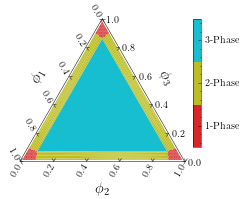

In [14]:
f = phase.polynomial_energy
ax = plot_result1(f, 'polynomial')

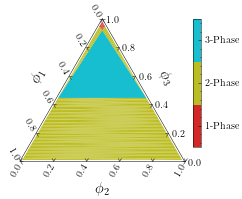

In [15]:
M = [10,10,1]
chi = [1.335, 1.0, 1.0]
f = lambda x : phase.flory_huggins(x, M, chi, logapprox=True)
ax = plot_result1(f, 'type3')

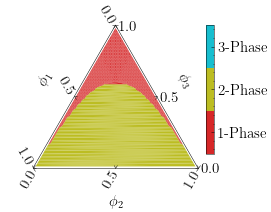

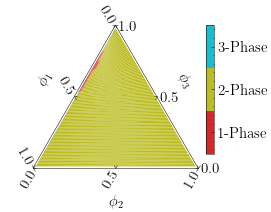

In [38]:
# type 1: classic parabola ternary
M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : phase.flory_huggins(x, M, chi)
ax = plot_result1(f, 'type1')


# type 2: One phase region near the polymer axis
M = [946,12,1]
chi = [0.472689,0.565626,0.651095]
f = lambda x : phase.flory_huggins(x, M, chi)
ax = plot_result1(f, 'type2')


## Quaternary Plot examples

In [17]:
M, chi = phase.get_sample_data(2)
quaternaries = {0: {'M':M,'chi':chi},
                1: {'M':[1120.63, 14.404, 2.413, 1.0], 'chi': [0.379,0.436,1.896,0.583,2.393,1.320], 
                    'info':['PM6','Y6','Butyl Benzoate','Acetone']},
               }

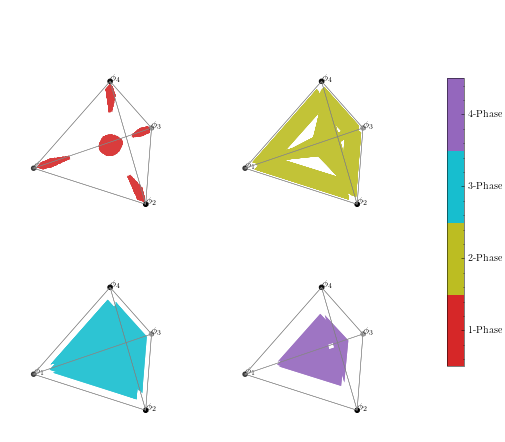

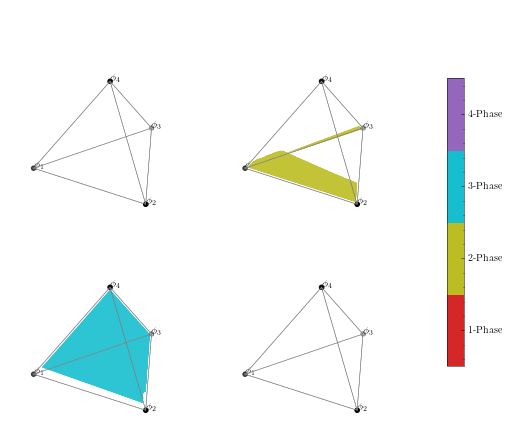

In [18]:
for key, value in quaternaries.items():
    M = value['M']
    chi = value['chi']
    f = lambda x : phase.flory_huggins(x, M, chi)
    engine = phase.PHASE(f,100,len(M))
    engine.compute()
    render = phase.QuaternaryPlot(engine)
    fig, axs, cbar = render.plot_simplices()

    plt.savefig('../figures/final/result3_{}.png'.format(key), 
                dpi=400, bbox_inches='tight')

## Angles and dot products

3-dimensional grid generated at 0.05s
Energy computed at 0.09s
Aplpying 2x padding of 59.28 maximum energy
Energy is corrected at 0.33s
Simplices are computed and refined at 0.36s
Total of 325 simplices in the convex hull
Using 1.43E-01 as a threshold for Laplacian of a simplex
Simplices are labelled at 0.58s
Labels are lifted at 0.69s
Total 0/325 coplanar simplices
Computation took 0.69s


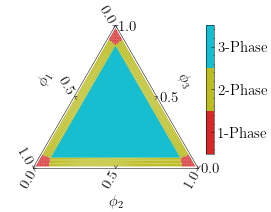

In [37]:
f = lambda x : phase.polynomial_energy(x)
engine = phase.PHASE(f,100,3)
engine.compute(use_parallel=False, verbose=True, lift_label=True)
render = phase.TernaryPlot(engine)
ax, cbar = render.plot_simplices()

In [20]:
# gradients
grid = engine.grid
num_comps = engine.num_comps
simplices = engine.simplices
energy = engine.energy

# Central difference gradient computation
class CentralDifference:
    """Compute central difference gradinet of energy
    Works only for a 3-dimensional grid or a ternary system
    change the energy formulation
    """
    def __init__(self, grid, energy):
        if callable(energy):
            self.func = energy
        else:
            raise RuntimeError

    def __call__(self,phi, h = 1e-3):
        """
        x,y : coordinates (float)
        h   : gridspacing (float)

        """
        p1,p2,p3 = phi
        f_right = self.func([p1+h,p2,1-p1-h-p2])
        f_left = self.func([p1-h,p2,1-p1+h-p2])
        df_dx = (f_right - f_left)/(2*h)
        
        f_right = self.func([p1,p2+h,1-p1-h-p2])
        f_left = self.func([p1,p2-h,1-p1+h-p2])
        df_dy = (f_right - f_left)/(2*h)
        
        return [df_dx, df_dy]
    
centraldiff_gradient = CentralDifference(grid, f)    
grad_cd = np.asarray([centraldiff_gradient(phi, h = 1e-6) for phi in grid.T])

# Analytical gradient for polynomial free energy
def _grad_polynomial(x):
    
    grad = 2*(x-0.1)*(0.9-x)*(1-2*x)
    
    return grad*1e3

def polynomial_gradient(x,**kwargs):
    grad = []
    df_dx3 = 2*1e3*(0.9-x[0]-x[1])*(x[0]+x[1]-0.1)*(1-2*x[0]-2*x[1])
    for xi in x[:2]:
        df_dxi = _grad_polynomial(xi)
        grad.append(df_dxi + df_dx3)
        
    return grad

analytic_gradient = lambda phi : polynomial_gradient(phi)


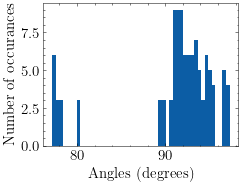

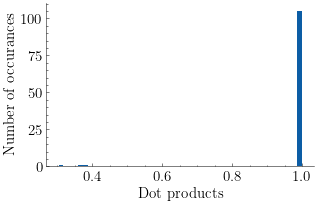

In [36]:
# get all angles of all 2-phase simplices
phase_simplices_ids = np.where(np.asarray(num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    test = phase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    test_out = test.get_angles(centraldiff_gradient)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)        
assert len(outlist)==len(phase_simplices_ids)*3    
fig, ax = plt.subplots()
ax.hist(outlist[:,0],bins=50, density=False)
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Number of occurances')

fig, ax = plt.subplots(figsize=(3*1.6, 3))
ax.hist(outlist[:,1],bins=50, density=False)
ax.set_xlabel('Dot products')
ax.set_ylabel('Number of occurances')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.savefig('../figures/final/tangentnormal_dotprods.png', dpi=400, bbox_inches='tight')

Angle at vertex 0 is 106.65 degrees
Angle at vertex 1 is 106.65 degrees
Angle at vertex 2 is 101.94 degrees


/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid va

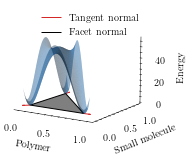

In [22]:
def touchup3d(ax):
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    #ax.zaxis._axinfo['juggled'] = (1,2,0)
    
test = phase.TestAngles(engine,phase=3)
test_out = test.get_angles(centraldiff_gradient)
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))

fig,ax = test.visualize(required=[1,2])
touchup3d(ax)
ax.view_init(elev=11, azim=-57)
ax.legend()
plt.savefig('../figures/final/TestAngles3D.png', dpi=400, bbox_inches='tight')

## Comparing gradient computations


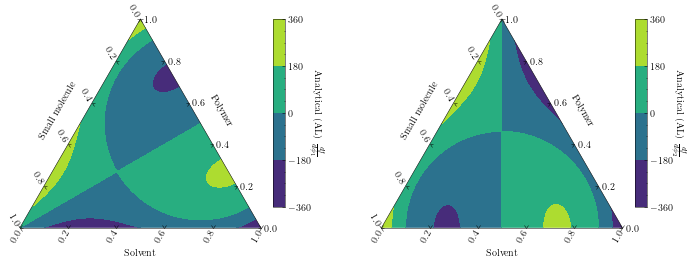

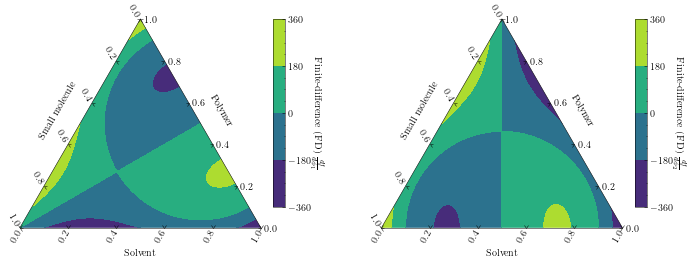

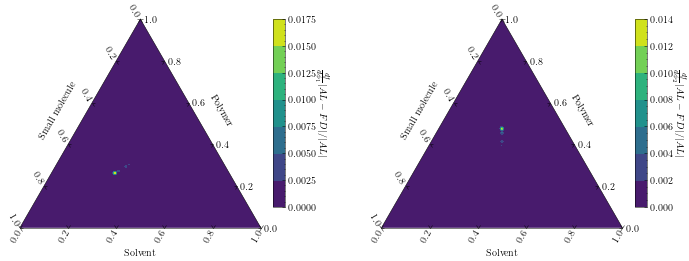

In [23]:
import matplotlib.gridspec as gridspec

def plot_gradient_field(grid, gradient, ax,**kwargs):
    fig = plt.gcf()
    cs = ax.tricontourf(grid[0,:], grid[1,:], grid[2,:], gradient,**kwargs)
    cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    cbar = fig.colorbar(cs, cax=cax)
    
    ax.set_tlabel('Polymer')
    ax.set_llabel('Small molecule')
    ax.set_rlabel('Solvent')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')
    ax.set_aspect('equal')
    
    return ax, cbar

grad = np.nan_to_num(np.asarray([analytic_gradient(x) for x in grid.T]))
grad_cd = np.nan_to_num(np.asarray([centraldiff_gradient(x, h = 1e-6) for x in grid.T]))

vmin=grad_cd.min()
vmax=grad_cd.max()
levels = np.linspace(vmin, vmax, num=5)

# a) analytical gradient
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)

ax = fig.add_subplot(1, 2, 1, projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,0], ax, levels=levels)
cbar.set_label(r'Analytical (AL) $\frac{df}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(1, 2, 2, projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,1], ax, levels=levels)
cbar.set_label(r'Analytical (AL) $\frac{df}{d\phi_2}$', rotation=270, va='baseline')
plt.savefig('../figures/final/analytical_gradient_polynomial.png', dpi=400, bbox_inches='tight')

# b) Finite difference
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)

ax = fig.add_subplot(1, 2, 1, projection='ternary')
ax,cbar = plot_gradient_field(grid, grad_cd[:,0], ax, levels=levels)
cbar.set_label(r'Finite-difference (FD) $\frac{df}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(1, 2, 2, projection='ternary')
ax,cbar = plot_gradient_field(grid,grad_cd[:,1], ax, levels=levels )
cbar.set_label(r'Finite-difference (FD) $\frac{df}{d\phi_2}$', rotation=270, va='baseline')
plt.savefig('../figures/final/finitediff_gradient_polynomial.png', dpi=400, bbox_inches='tight')

# difference
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)

ax = fig.add_subplot(1, 2, 1, projection='ternary')
cvalue = np.abs(grad_cd[:,0]-grad[:,0])/np.abs(grad[:,0])
ax,cbar = plot_gradient_field(grid, cvalue, ax)
cbar.set_label(r'$\frac{df}{d\phi_1} |AL-FD|/|AL|$', rotation=270, va='baseline')

ax = fig.add_subplot(1, 2, 2, projection='ternary')
cvalue = np.abs(grad_cd[:,1]-grad[:,1])/np.abs(grad[:,1])
ax,cbar = plot_gradient_field(grid, cvalue, ax)
cbar.set_label(r'$\frac{df}{d\phi_2} |AL-FD|/|AL|$', rotation=270, va='baseline')
plt.savefig('../figures/final/comparision_polynomial.png', dpi=400, bbox_inches='tight')

## Hyper parameter search plot
This plot takes a lot of time so we run it on CCR

 row=0, col=0, dx=50, Delta=5
 row=0, col=1, dx=100, Delta=5
 row=0, col=2, dx=200, Delta=5
 row=0, col=3, dx=300, Delta=5
 row=1, col=0, dx=50, Delta=10
 row=1, col=1, dx=100, Delta=10
 row=1, col=2, dx=200, Delta=10
 row=1, col=3, dx=300, Delta=10
 row=2, col=0, dx=50, Delta=20
 row=2, col=1, dx=100, Delta=20
 row=2, col=2, dx=200, Delta=20
 row=2, col=3, dx=300, Delta=20


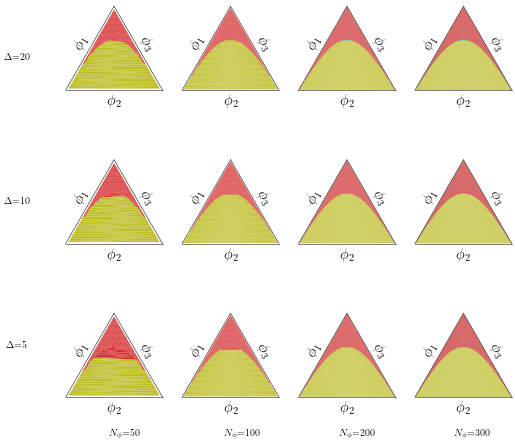

In [31]:
import numpy as np
import polyphase
import matplotlib.pyplot as plt

M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : polyphase.flory_huggins(x, M, chi)
Deltas_row = [5,10,20]
dxs_col = [50,100,200,300]
fig,axs = plt.subplots(3,4,subplot_kw={'projection':'ternary'}, figsize=(8,8))
#fig.subplots_adjust(wspace=0.5, hspace=0.6)
row_spacing = [1/4,2/4,3/4]
col_spacing = [1/5,2/5,3/5,4/5]
for i,Delta in enumerate(Deltas_row):       
        fig.text(0.04, row_spacing[i], r'$\Delta$={}'.format(Delta), ha='center')
for j, dx in enumerate(dxs_col):        
        fig.text(col_spacing[j],0.1,  r'$N_{\phi}$'+'={}'.format(dx), va='center')
        
for i,Delta in enumerate(Deltas_row):
    for j, dx in enumerate(dxs_col):
        engine = polyphase.PHASE(f,dx,3)
        engine.compute(use_parallel=False, verbose=False,
                       thresh_scale=Delta, lift_label=True)
        render = polyphase.TernaryPlot(engine)
        ax, cbar = render.plot_simplices(ax=axs[i,j])
        ax.taxis.set_tick_params(which='both', bottom=False, top=False, labelbottom=False)
        ax.laxis.set_tick_params(which='both', bottom=False, top=False, labelbottom=False)
        ax.raxis.set_tick_params(which='both', bottom=False, top=False, labelbottom=False)
        cbar.remove()
        print(' row={}, col={}, dx={}, Delta={}'.format(i,j, dx, Delta))

plt.savefig('../figures/final/hyperparams.png', dpi=400, bbox_inches='tight')